In [11]:
import optuna
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import ARIMA
from utilsforecast.evaluation import evaluate

import warnings
import logging

warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("optuna").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [12]:
# Definir las métricas
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Evaluación de métricas
def evaluate(cv_df, metrics):
    results = {}
    for metric in metrics:
        y_true = cv_df['y'].values
        y_pred = cv_df['ARIMA'].values
        results[metric.__name__] = metric(y_true, y_pred)
    return results

In [13]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [14]:
horizon = 3

In [15]:
# Definir función para optimización por ticker
def optimize_for_ticker(ticker):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    print(f"Number of observations for {ticker}: {len(Y_df_ticker)}")

    # Eliminar filas con NaN en la columna 'y'
    if Y_df_ticker['y'].isnull().any():
        print(f"NaN values found in {ticker}. Cleaning data...")
        Y_df_ticker = Y_df_ticker.dropna(subset=['y']) 

    # Diccionario para almacenar las métricas
    metrics_dict = {}

    # Definir función objetivo para Optuna
    def objective(trial):
        order = (trial.suggest_int('p', 0, 2), 
                 trial.suggest_int('d', 0, 1), 
                 trial.suggest_int('q', 0, 2))
        seasonal_order = (trial.suggest_int('P', 0, 1), 
                          trial.suggest_int('D', 0, 1), 
                          trial.suggest_int('Q', 0, 1))
        season_length = trial.suggest_int('season_length', 1, min(12, len(Y_df_ticker)))

        # Instanciar el modelo ARIMA
        model = ARIMA(order=order, seasonal_order=seasonal_order, season_length=season_length)

        sf = StatsForecast(df=Y_df_ticker, models=[model], freq='MS', n_jobs=-1)

        # Validación cruzada
        cv_df = sf.cross_validation(df=Y_df_ticker, h=horizon, step_size=horizon, n_windows=5).reset_index()

        # Evaluación de las predicciones
        evaluation_results = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[smape, mape, mse, mae, rmse])

        # Guardar las métricas para el análisis posterior
        metrics_dict[trial.number] = {
            'smape': evaluation_results['smape'],
            'mape': evaluation_results['mape'],
            'mse': evaluation_results['mse'],
            'mae': evaluation_results['mae'],
            'rmse': evaluation_results['rmse']
        }

        return evaluation_results['smape']

    # Optimización con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=25)

    best_params = study.best_params
    best_trial = study.best_trial.number

    print(f"Best hyperparameters for {ticker}: {best_params}")
    print(f"Best SMAPE for {ticker}: {study.best_value}")
    print(f"Metrics for the best trial ({best_trial}): {metrics_dict[best_trial]}")

    return best_params, metrics_dict[best_trial]


In [16]:
# Crear modelo y predecir
def create_model_and_predict(ticker, best_params):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    # Crear modelo final con los mejores parámetros
    final_model = ARIMA(
        order=(best_params['p'], best_params['d'], best_params['q']),
        seasonal_order=(best_params['P'], best_params['D'], best_params['Q']),
        season_length=best_params['season_length']
    )

    sf_final = StatsForecast(df=Y_df_ticker, models=[final_model], freq='MS', n_jobs=-1)

    prediction_length = len(Y_df_ticker) - horizon
    Y_df_real = Y_df_ticker[:prediction_length]

    sf_final.fit(Y_df_real)
    forecast = sf_final.forecast(h=horizon)

    print(f"Predictions for {ticker}:")
    print(forecast)

    return forecast

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_predictions(ticker, forecast):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]
    
    # Create the plot
    plt.figure(figsize=(12, 6))

    # Actual data (historical)
    real_series = Y_df_ticker[['ds', 'y']]  
    plt.plot(real_series['ds'], real_series['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Predictions
    forecast_series = forecast[['ds', 'ARIMA']]
    plt.plot(forecast_series['ds'], forecast_series['ARIMA'], label='Prediction', marker='x', color='orange', linestyle='--', linewidth=2)

    # Configure the plot
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    
    # Set the x-axis limits to encompass both actual and forecast data
    all_dates = pd.concat([real_series['ds'], forecast_series['ds']])  # Define all_dates here
    plt.xlim([pd.Timestamp('2024-01-01'), all_dates.max() + pd.DateOffset(months=1)])  # Cutting the graph from January 1, 2024

    # Set the y-axis limit based on the ticker
    if ticker.lower() == 'nvda':
        plt.ylim(bottom=40)  # NVDA starts from 40
    elif ticker.lower() == 'btc-usd':
        plt.ylim(bottom=35000)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'msft':
        plt.ylim(bottom=340)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'amzn':
        plt.ylim(bottom=140)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'meta':
        plt.ylim(bottom=300)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'aapl':
        plt.ylim(bottom=140)  # BTC-USD starts from 30,000
    else:
        plt.ylim(bottom=120)  # All other tickers start from 150

    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Display the plot
    plt.tight_layout()
    plt.show()


In [18]:
# Optimización para cada ticker
best_params_dict = {}
for ticker in tickers:
    print(f"\nOptimizando para {ticker}...")
    best_params, best_metrics = optimize_for_ticker(ticker)
    if best_params is not None:
        best_params_dict[ticker] = best_params


Optimizando para AAPL...
Number of observations for AAPL: 298


Best hyperparameters for AAPL: {'p': 2, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'season_length': 8}
Best SMAPE for AAPL: 6.075010448694229
Metrics for the best trial (0): {'smape': 6.075010448694229, 'mape': 5.861534550786018, 'mse': 269.72403, 'mae': 11.704631, 'rmse': 16.423277}

Optimizando para MSFT...
Number of observations for MSFT: 298
Best hyperparameters for MSFT: {'p': 1, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 1, 'season_length': 7}
Best SMAPE for MSFT: 5.314784124493599
Metrics for the best trial (14): {'smape': 5.314784124493599, 'mape': 5.25452233850956, 'mse': 626.37366, 'mae': 20.547468, 'rmse': 25.027458}

Optimizando para GOOGL...
Number of observations for GOOGL: 242
Best hyperparameters for GOOGL: {'p': 0, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 1, 'season_length': 12}
Best SMAPE for GOOGL: 5.940950661897659
Metrics for the best trial (7): {'smape': 5.940950661897659, 'mape': 5.785113573074341, 'mse': 111.340836, 'mae': 8.782963, 'rmse': 10.551817}

Optimizando para AMZN.

In [19]:
# Crear y predecir
import time
forecasts_dict = {}

for ticker in tickers:
    if ticker in best_params_dict:
        print(f"\nCreando el modelo y realizando predicciones para {ticker}...")

        start_time = time.time()
        forecast = create_model_and_predict(ticker, best_params_dict[ticker])
        end_time = time.time()

        print(f"Tiempo de predicción para {ticker}: {end_time - start_time:.2f} segundos")
        forecasts_dict[ticker] = forecast


Creando el modelo y realizando predicciones para AAPL...
Predictions for AAPL:
                  ds       ARIMA
unique_id                       
AAPL      2024-08-01  223.285370
AAPL      2024-09-01  222.674210
AAPL      2024-10-01  229.655014
Tiempo de predicción para AAPL: 1.57 segundos

Creando el modelo y realizando predicciones para MSFT...
Predictions for MSFT:
                  ds       ARIMA
unique_id                       
MSFT      2024-08-01  435.621704
MSFT      2024-09-01  449.513397
MSFT      2024-10-01  454.844574
Tiempo de predicción para MSFT: 1.31 segundos

Creando el modelo y realizando predicciones para GOOGL...
Predictions for GOOGL:
                  ds       ARIMA
unique_id                       
GOOGL     2024-08-01  174.987869
GOOGL     2024-09-01  170.330978
GOOGL     2024-10-01  171.909317
Tiempo de predicción para GOOGL: 1.52 segundos

Creando el modelo y realizando predicciones para AMZN...
Predictions for AMZN:
                  ds       ARIMA
unique_id  


Graficando las predicciones para AAPL...


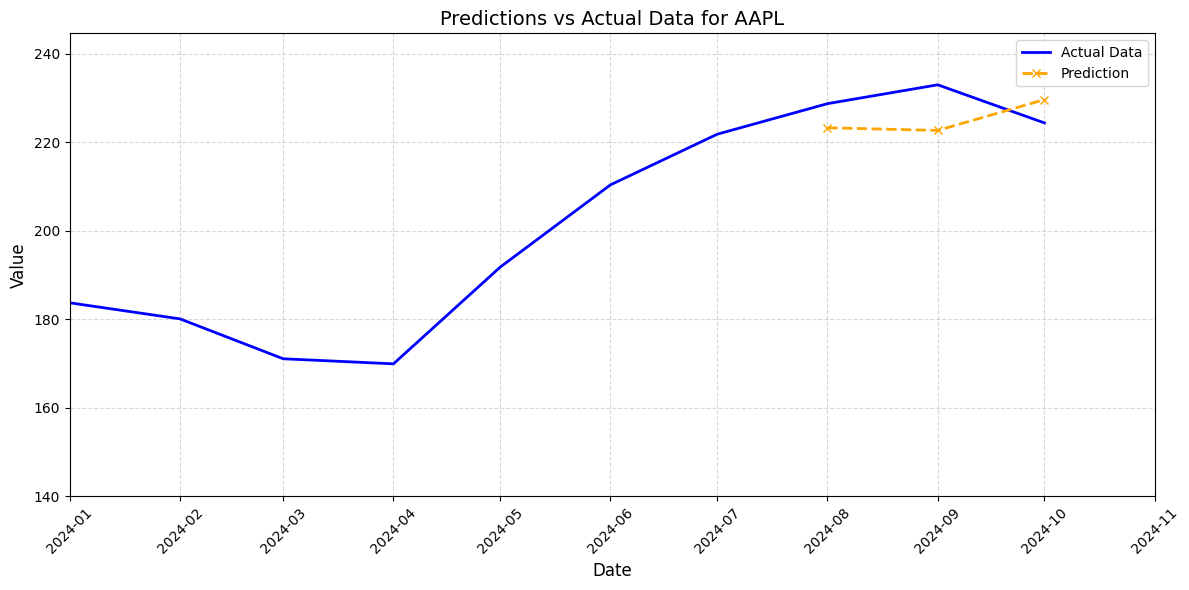


Graficando las predicciones para MSFT...


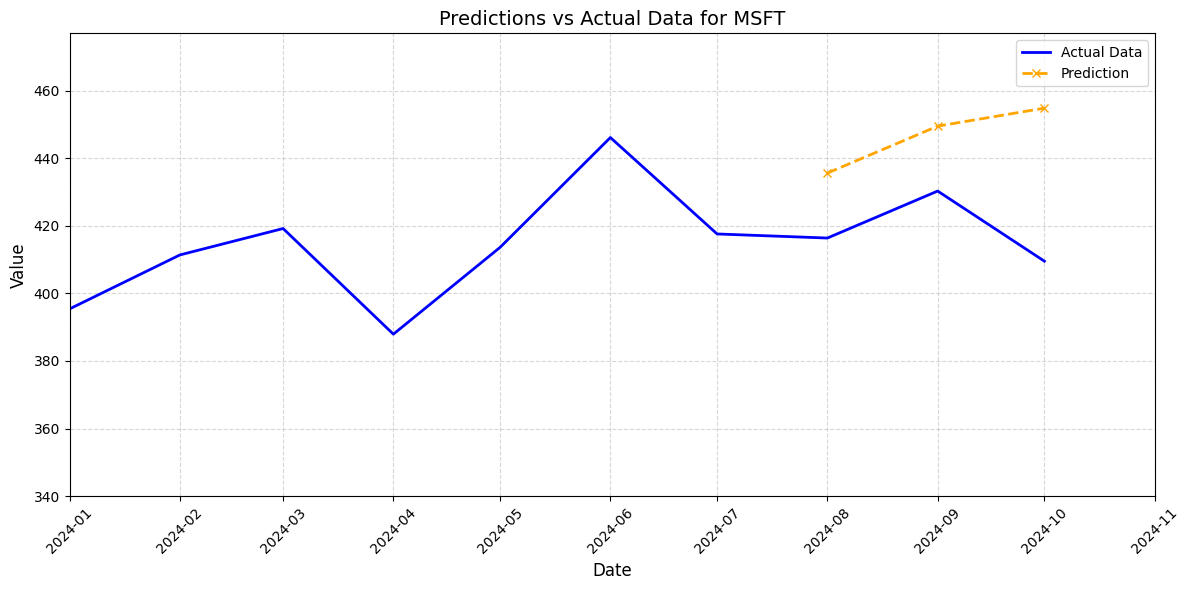


Graficando las predicciones para GOOGL...


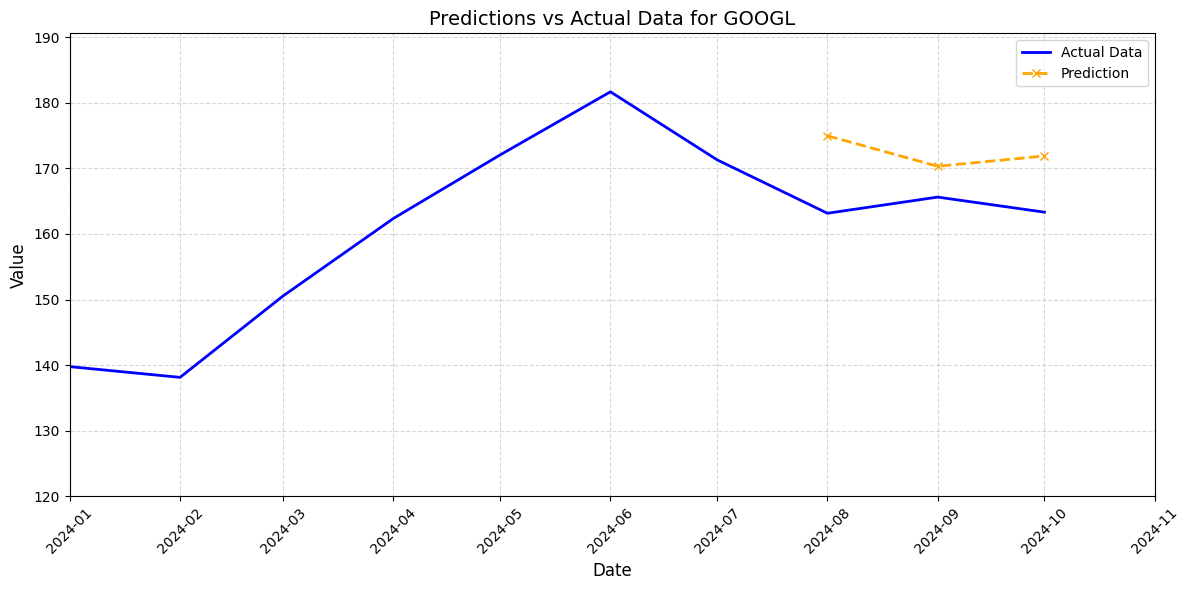


Graficando las predicciones para AMZN...


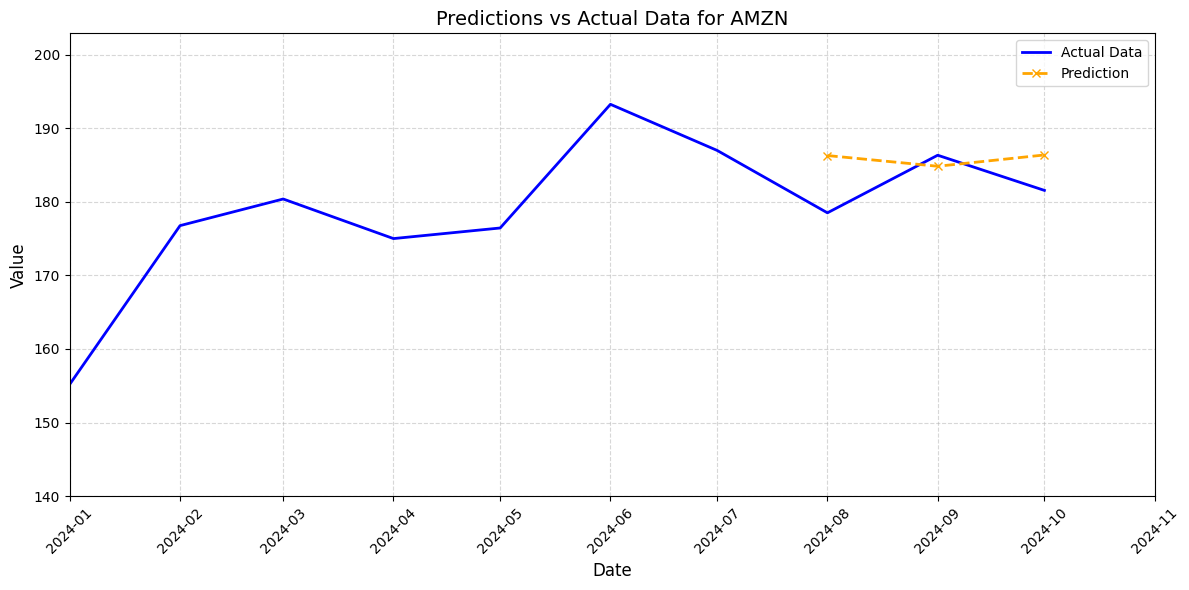


Graficando las predicciones para NVDA...


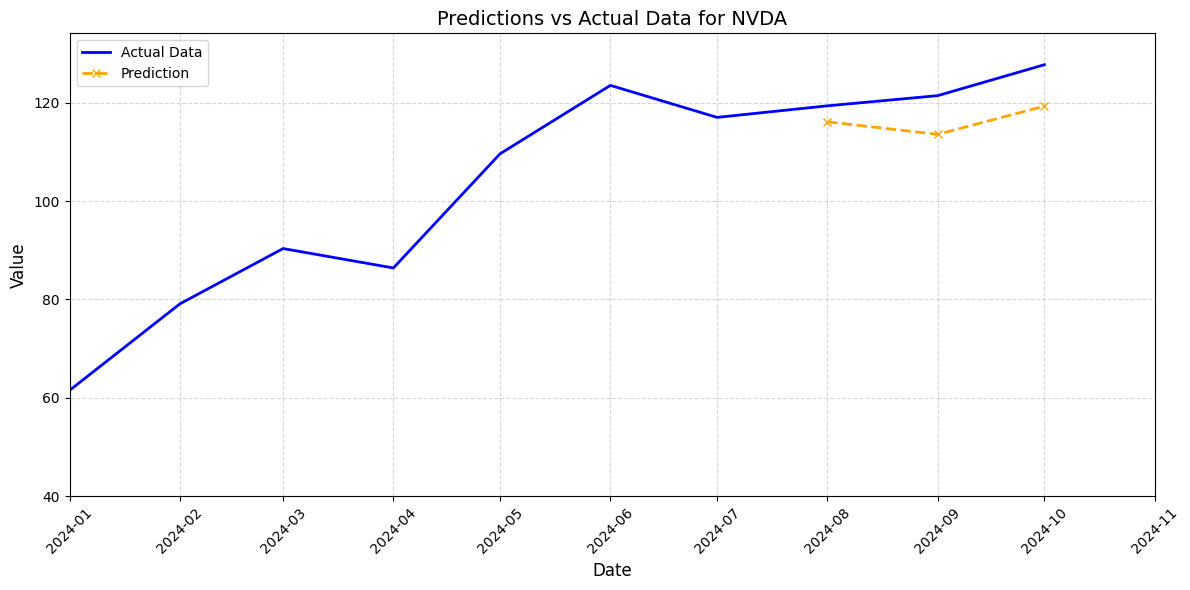


Graficando las predicciones para META...


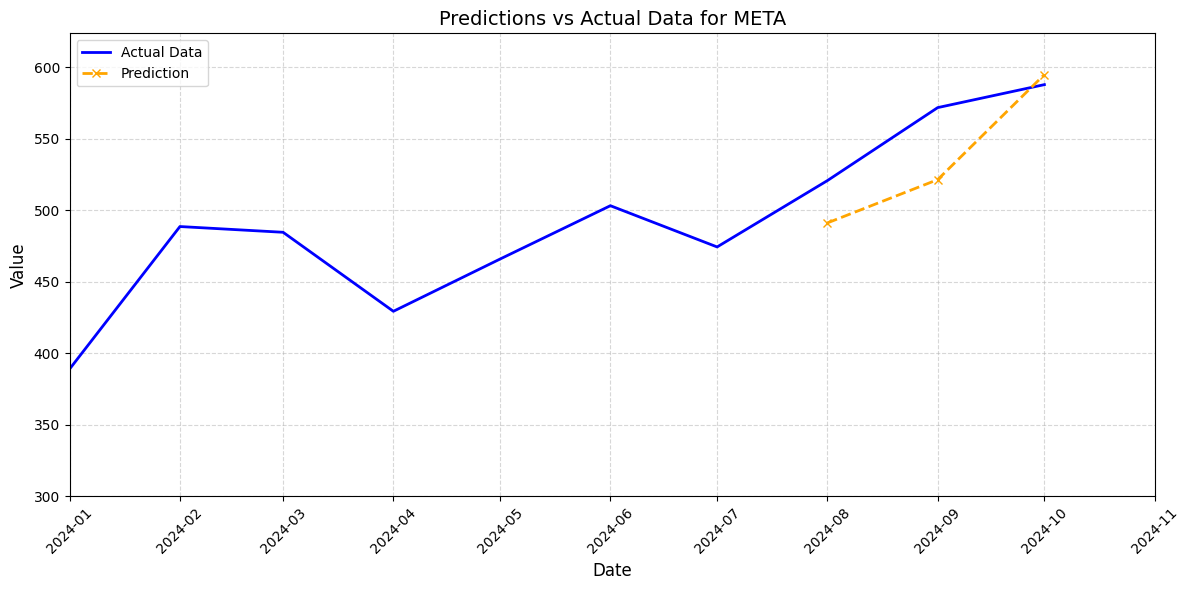


Graficando las predicciones para IBM...


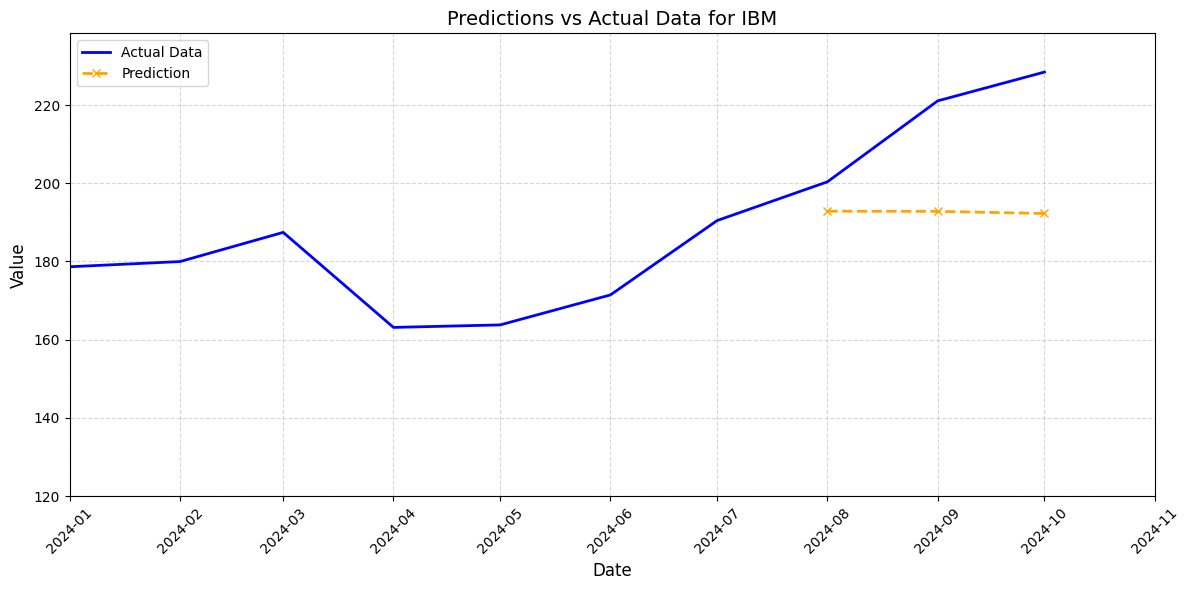


Graficando las predicciones para BTC-USD...


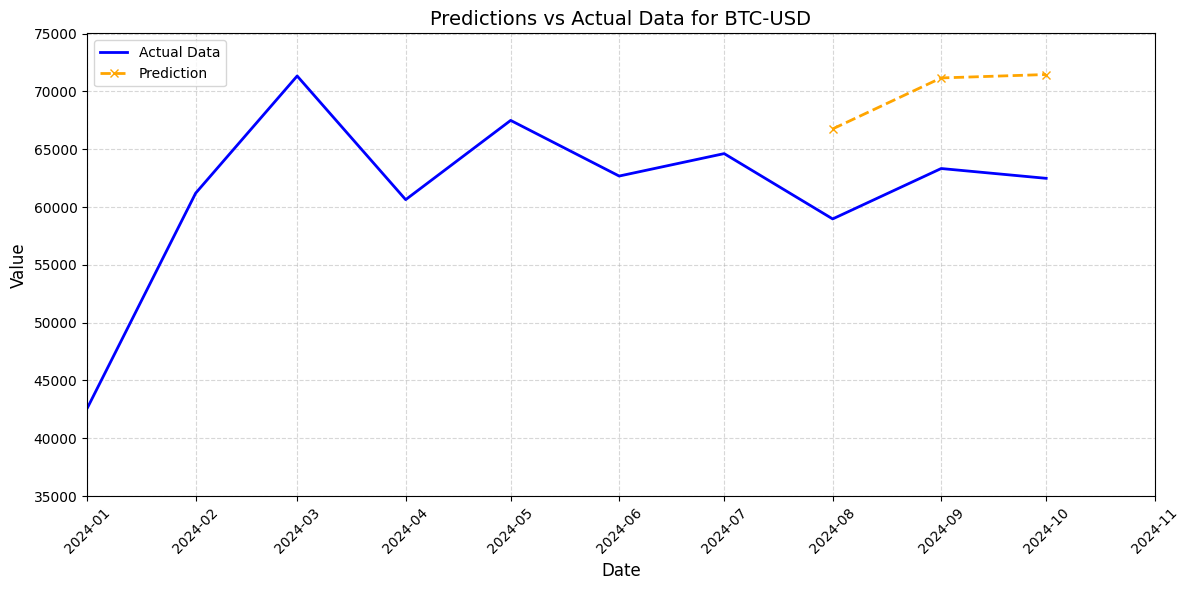

In [25]:
# Graficar resultados
for ticker in forecasts_dict:
    print(f"\nGraficando las predicciones para {ticker}...")
    plot_predictions(ticker, forecasts_dict[ticker])